<a href="https://colab.research.google.com/github/emyesme/ExpectationMaximizationAlgorithm/blob/main/EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## libraries

In [3]:
from matplotlib import pyplot as plt
from skimage import measure
from scipy import stats
import nibabel as nib
import numpy as np
import cv2
import os


from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## functions

In [5]:
# kmeans clustering segmentation 
# vector: matrix: large x 1 -> of intensity values of the brain
# k: number -> quantity of clusters
# return: matrix, matrix 
def segmentation_kmeans(vector, k):
    # color space change
    # matrix = cv2.cvtColor(matrix, cv2.COLOR_BGR2RGB)
    # reshape the image to be a list of pixels
    data = np.float32(vector)

    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # Apply KMeans
    compactness,labels,centers = cv2.kmeans(data,k,None,criteria,10,flags)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    res2 = res.reshape((vector.shape))

    mask = cv2.normalize(res2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    #print(mask.shape)
    
    return mask, labels

In [6]:
# given volume, labels and ground truth
# return the vectors of intensity 
# corresponding to csf, wm and gm respectively
# reshape_kmeans: array large x 1 -> volume of labels
# brain: array  240 x 240 x 48 -> volume of intensities of the brain
# gt: array 240 x 240 x 48 -> ground truth
# result: array, array, array
def get_vector_image(reshape_kmeans, brain, gt):
  
  csf = np.multiply((reshape_kmeans == 2)[gt>0], brain)
  wm = np.multiply((reshape_kmeans == 1)[gt>0], brain)
  gm = np.multiply((reshape_kmeans==0)[gt > 0], brain)

  #m = np.where(gt != 0)

  return csf, wm, gm

In [7]:
# given volume of 2 different sequences return mean and standard deviation
# t1: array  240 x 240 x 48 -> volume of intensities of the brain of one sequence
# flair: array 240 x 240 x 48 -> volume of intensities of the brain of other sequence
# result: array, array -> meand and std for each sequence respectively
def init_mean_cov(t1, flair):

  mean1 = np.mean(t1)
  mean2 = np.mean(flair)
  mean_f = np.vstack((mean1, mean2))

  std_f = np.cov(t1,flair)  

  return mean_f, std_f

In [8]:
# given intensities, weights for a cluster k and nk compute the empirical avg standard
# x: array  2 x large -> volume of intensities of the brain of one sequence
# wk: array large x 1 -> weights in each pixel for cluster k
# nk: number -> sum of all the weights in a cluster k
# result: array 2 x 1 -> meand and std for each sequence respectively
def new_mean(x, wk, nk):  

  result = np.sum(np.multiply(wk, x[:,0,:]), axis=1)

  return result/nk


In [9]:
# given intensities, weights for a cluster k and nk compute the empirical avg standard
# dif: array  2 x large -> difference of intensities with corresponding mean for each pixel
# wk: array large x 1 -> weights in each pixel for cluster k
# nk: number -> sum of all the weights in a cluster k
# result: array 2 x 1 -> meand and std for each sequence respectively
def new_cov(dif, wk, nk):

  result = np.matmul(np.multiply(wk, dif), np.transpose(dif))
  
  return result / nk

In [10]:
# mulvariate gaussian density
# dif: array 2 x large -> xi - mu for each cluster ki
# dim: number -> number of dimensions in this case 2 sequences t1 and flair 
# detstd: array 1 x 3 -> determinant of covariance matrix for each cluster 
# invstd: array 2x2 x 3  -> inverses of matrices of covariance fir each cluster
# result: number
def gauss_mix_model(dif, dim, detstd, invstd):

  tdif = np.transpose(dif)
  pow = (-0.5) * np.matmul(np.matmul( tdif, invstd), (dif)).reshape(-1)[0]
  den = ((2 * np.pi) ** (dim/2)) * (detstd ** (0.5))
  result = ( 1 / den ) * np.exp(pow)

  return result

# compute inverse and determinant of std
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
# result: array, array
def inv_det_std(std):
  # compute inverse of covariance matrices
  invstd = np.array([ [np.linalg.inv(std[0,:,:,:][0])],
                      [np.linalg.inv(std[1,:,:,:][0])],
                      [np.linalg.inv(std[2,:,:,:][0])]])

  # compute determinant of covariance matrices
  detstd = np.array([ np.linalg.det(std[0,:,:,:][0]),
                      np.linalg.det(std[1,:,:,:][0]),
                      np.linalg.det(std[2,:,:,:][0])])
  return invstd, detstd

# multivariate gaussian probability density function
# x: 2 x large -> intensities vector
# k: number -> number of clusters
# mu: array  2x3 -> avg of values for each cluster and dimension
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
def prior_probs_lib(x, k, mu, std ):

  p_gauss = np.zeros((x.shape[2],k))

  for ki in range(k):
    # compute multivariate gaussian
    p_gauss[:,ki] = stats.multivariate_normal.pdf(np.transpose(x[:,0,:]), mean=np.array(mu[:,ki]), cov=std[ki,:,:,:][0])

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[:,ki]]), x.shape[2], axis=1)

    # compute x - u
    dif = x[:,0,:] - rmu
  
  return p_gauss, dif


# prior probabilities computation
# x: 2 x large -> intensities vector
# k: number -> number of clusters
# mu: array  2x3 -> avg of values for each cluster and dimension
# std: array (2x2)x3  -> 3 matrices of covariance (2x2)
# dim: number -> number of dimensions in this case 2 sequeneces t1 and flair
def prior_probs(x, k, mu, std, dim):
  # membership matrix variables
  p_gauss = np.zeros((x.shape[2],k))

  # compute inv and det of std
  invstd, detstd = inv_det_std(std)

  # for each cluster k
  for ki in range(k):

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[:,ki]]), x.shape[2], axis=1)

    # compute x - u
    dif = x[:,0,:] - rmu

    # compute individual memberships
    for dif_i in range(dif.shape[1]):
      # compute the membership of given intensity value to the cluster ki
      p_gauss[dif_i, ki] = gauss_mix_model(dif[:,dif_i], dim, detstd[ki], invstd[ki,:,:,:][0])

  return p_gauss, dif


# compute the membership by cluster
# p_gauss 2 x large 
# alpha_k: array 1x3 -> proportion of points we have in each cluster
# result: weights matrix: n x k
def membership(p_gauss, alpha):
  
  # compute individual memberships n x k
  numerator = np.multiply(p_gauss, np.array(alpha))
  
  # compute all memberships for denominator of gaussian formula
  denominator = np.matmul(p_gauss, np.array(alpha)) # n x 1

  # for each numerator in i the denominator is the same for the 3 clusters
  rdenominator = np.transpose(np.repeat(np.array([denominator]), k, axis=0))
  
  # weights 
  weights = np.divide(numerator, rdenominator)

  # checking condition of sum row = 1
  #print("checksum ", (np.round(weights.sum(axis=1))==1).all())

  return weights

In [11]:
# Computes soerensen-dice coefficient.

# compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
# and the predicted mask `mask_pred`.

# Args:
#   mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
#   mask_pred: 3-dim Numpy array of type bool. The predicted mask.

# Returns:
#   the dice coeffcient as float. If both masks are empty, the result is NaN.
def compute_dice_coefficient(mask_gt, mask_pred):
  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  
  return 2*volume_intersect / volume_sum 

In [12]:
# get the right cluster

def get_right_cluster(gt, labels):
  knumbers = []
  for i in np.unique(labels):
    knumbers.append( np.sum(gt == i+1))
  
  knumbers = np.array(knumbers)
  print(knumbers)
  wm = np.argmax(knumbers)
  csf = np.argmin(knumbers)
  gm = [i for i in range(len(labels)) if (i != wm and i!=csf)][0]
  return csf, gm, wm   # em --> csf = 1, gm = 2, wm = 3

# Main algorithm

In [13]:
FOLDER_DIR = "/content/drive/MyDrive/MAIA/Semester3/MISA/P2_data/5"

patients = ['1', '2', '3', '4', '5']

# # import data
# for patient in patients:

img = nib.load(os.path.join(FOLDER_DIR, 'T1.nii')).get_fdata()
img_info = nib.load(os.path.join(FOLDER_DIR, 'T1.nii'))
#print(img_info.affine)
img_flair = nib.load(os.path.join(FOLDER_DIR,'T2_FLAIR.nii')).get_fdata()
gt = nib.load(os.path.join(FOLDER_DIR,  'LabelsForTesting.nii')).get_fdata()

# normalisation step
img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
img_flair = cv2.normalize(img_flair, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# skull stripping with the groundtruth mask
brain_t1 = img[gt > 0]
flair = img_flair[gt > 0]

# brain vector of intensities
vector_brain = brain_t1.reshape(-1)

# get kmeans to extract initialisation parameters
kmeans, labels = segmentation_kmeans(vector_brain, 3)
csf_knumber, gm_knumber, wm_knumber = get_right_cluster(gt, labels)

# initialising variable of kmeans labels
reshape_kmeans = np.zeros(img.shape)

# indexes of voxels that are part of the brain
m = np.where(gt != 0)


count = 0
for i, j, k in zip(m[0], m[1], m[2]):
    # reconstruction of labels
    reshape_kmeans[i, j, k] = labels[count]
    count += 1

[128927 210020 131282]


In [14]:
# INITIALIZE 

# get csf, wm and gm
csf_t1, wm_t1, gm_t1 =  get_vector_image(reshape_kmeans, brain_t1, gt)
csf_fl, wm_fl, gm_fl =  get_vector_image(reshape_kmeans, flair, gt)

# mean and std of csf, wm, gm
mean_csf, std_csf = init_mean_cov(csf_t1, csf_fl) # mean 2x1, std 2x2
mean_wm, std_wm = init_mean_cov(wm_t1, wm_fl)
mean_gm, std_gm = init_mean_cov(gm_t1, gm_fl)

# initial mu 2x3 and std (2x2)x3
mu = np.hstack((mean_csf, mean_wm, mean_gm))
std = np.array([ [std_csf], [std_wm], [std_gm] ])

# x array of pixels values for both dimensions
x = np.array([ [brain_t1],[flair] ]) # xi is 2x1. 2x1x(all brain pixels)

# initial alpha 
alpha = np.array([1/3,1/3,1/3])

# clusters
k = 3

# iterations
iterations = 500

# dimensions
dim = 2

# initial weights matrix
weights = np.zeros((x.shape[2], k), dtype=np.float32)

# COMPUTE LOGLIKELIHOOD

# compute inv and det of std
invstd, detstd = inv_det_std(std)

# membership matrix variables
# library so fast, 1 second per epoch
p_gauss, dif = prior_probs_lib(x, k, mu, std)
# our 30s per epoch
#p_gauss, dif = prior_probs(x, k, mu, std, dim)

# initial loglikelihood
log_likelihood = -100

In [15]:
# REPEAT while true
import time

start = time.time()

for iteration in range(iterations):

  # EXPECTATION STEP 
  
  # compute membership 
  weights = membership(p_gauss, alpha)

  # MAXIMITATION STEP

  # for each cluster
  for ki in range(k):

    # computing necessary things 
    rmu = np.repeat(np.transpose([mu[:,ki]]), x.shape[2], axis=1)

    # compute x - u
    dif = x[:,0,:] - rmu

    # compute  nk
    nk = np.sum(weights[:,ki])
    # compute alpha
    alpha[ki] = nk / x.shape[2]
    # compute mu 
    mu[:,ki] = new_mean(x, weights[:,ki], nk).reshape(-1)
    # compute std
    std[ki,:,:,:][0] = new_cov(dif, weights[:,ki], nk)
    
  # CONVERGENCE RULE

  # compute membership matrix
  
  # library so fast, 1 second per epoch
  p_gauss, dif = prior_probs_lib(x, k, mu, std)
  # our 30s per epoch
  #p_gauss, dif = prior_probs(x, k, mu, std, dim)

  p_gauss_alpha = np.matmul(p_gauss, np.array(alpha))

  # compute likelihood
  tmplikelihood = np.sum(np.log(p_gauss_alpha))
  
  # checking convergence criterion
  #print('dif ', (tmplikelihood - log_likelihood) )

  if np.abs(tmplikelihood - log_likelihood) < 1e-10:
    print("Convergence achieved before ending iterations!")
    break

  log_likelihood = tmplikelihood

  #print('iter ', iteration)

print('Final time: ', time.time()-start)

Convergence achieved before ending iterations!
Final time:  35.011634349823


In [ ]:
# Reconstruct the Brain 

m = np.where(gt != 0)
em = np.zeros(img.shape)
count = 0

for i, j, k in zip(m[0], m[1], m[2]):
    # reconstruction of labels
    em[i, j, k] = np.argmax(weights[count, :]) + 1
    count += 1


# csf_knumber, gm_knumber, wm_knumber
dice_csf = compute_dice_coefficient(gt == 1, em == 2)
dice_gm =  compute_dice_coefficient(gt == 2, em == 3)
dice_wm = compute_dice_coefficient(gt == 3, em == 1)

print(dice_csf)
print(dice_gm)
print(dice_wm)


0.8658943842017103
0.8464094862126433
0.8889990842234495


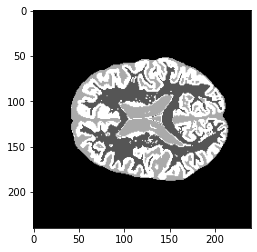

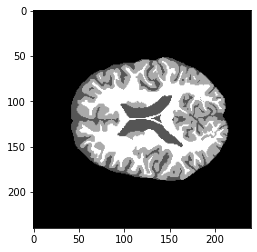

In [ ]:
plt.imshow(em[:,:,24], cmap='gray') # em --> csf = 3, gm = 2, wm = 1
plt.show()
plt.imshow(gt[:,:,24], cmap='gray') # gt --> csf = 1, gm = 2, wm = 3
plt.show()

In [ ]:
data = np.ones(img.shape, dtype=np.int16)
img_new = nib.Nifti1Image(em, img_info.affine)
img_new.get_data_dtype() == np.dtype(np.int16)

nib.save(img_new, '/content/drive/MyDrive/MAIA/Semester3/MISA/P2_data/5/volume_patient5.nii')